In [150]:
# ==========================================
# 1. Imports & Configuration
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve

# Configuration
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [151]:
df = pd.read_csv("clinical_data.csv")
df.head()

,Patient_ID,Age,Sex,Weight_Kg,Dose_Per_Kg,Baseline_Severity,Responder_Status,Biomarker_Day0,Biomarker_Day1,Biomarker_Day2,Biomarker_Day3,Biomarker_Day4,Biomarker_Day5
0,P0000,55,Female,57,8.771930,4,1,24.475772,18.710462,5000.000000,15.661013,10.589811,8.050132
1,P0001,51,Male,65,7.692308,7,1,38.147798,35.245467,25.447169,-50.000000,11.993499,7.530111
2,P0002,60,Male,90,5.555556,5,0,49.580291,51.577749,52.194047,45.069320,43.180396,45.408444
3,P0003,53,Female,71,7.042254,8,1,38.870393,30.888352,19.962496,19.973790,14.521031,8.403000
4,P0004,53,Male,65,7.692308,7,1,19.678144,12.572271,10.209340,5.903636,3.733401,0.816715


In [152]:
df.duplicated().sum()

np.int64(0)

In [153]:
df.isnull().sum()

Patient_ID             0
Age                    0
Sex                    0
Weight_Kg              0
Dose_Per_Kg            0
Baseline_Severity      0
Responder_Status       0
Biomarker_Day0         0
Biomarker_Day1       103
Biomarker_Day2       123
Biomarker_Day3        99
Biomarker_Day4       109
Biomarker_Day5       102
dtype: int64

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         2000 non-null   object 
 1   Age                2000 non-null   int64  
 2   Sex                2000 non-null   object 
 3   Weight_Kg          2000 non-null   int64  
 4   Dose_Per_Kg        2000 non-null   float64
 5   Baseline_Severity  2000 non-null   int64  
 6   Responder_Status   2000 non-null   int64  
 7   Biomarker_Day0     2000 non-null   float64
 8   Biomarker_Day1     1897 non-null   float64
 9   Biomarker_Day2     1877 non-null   float64
 10  Biomarker_Day3     1901 non-null   float64
 11  Biomarker_Day4     1891 non-null   float64
 12  Biomarker_Day5     1898 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage: 203.3+ KB


In [155]:
df.describe()

,Age,Weight_Kg,Dose_Per_Kg,Baseline_Severity,Responder_Status,Biomarker_Day0,Biomarker_Day1,Biomarker_Day2,Biomarker_Day3,Biomarker_Day4,Biomarker_Day5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,1897.000000,1877.000000,1901.000000,1891.000000,1898.000000
mean,59.791500,78.171000,6.679212,6.504500,0.614000,26.767738,24.038004,24.651210,20.295557,19.278339,18.579480
std,12.227828,15.594722,1.492228,1.679402,0.486952,8.021094,8.519652,115.332062,11.779306,13.638437,15.428041
min,21.000000,25.000000,3.875969,4.000000,0.000000,9.060611,6.263442,1.185623,-50.000000,0.100000,0.100000
25%,51.000000,67.750000,5.617978,5.000000,0.000000,21.146824,18.087079,14.671987,11.795392,9.303701,7.447277
50%,60.000000,78.000000,6.410256,6.500000,1.000000,25.591996,22.805926,19.939216,16.927375,14.371574,12.030404
75%,68.000000,89.000000,7.380378,8.000000,1.000000,30.943101,28.401586,27.165547,26.647701,27.117193,27.756394
max,101.000000,129.000000,20.000000,9.000000,1.000000,64.487081,73.188950,5000.000000,80.932905,87.828436,101.544295


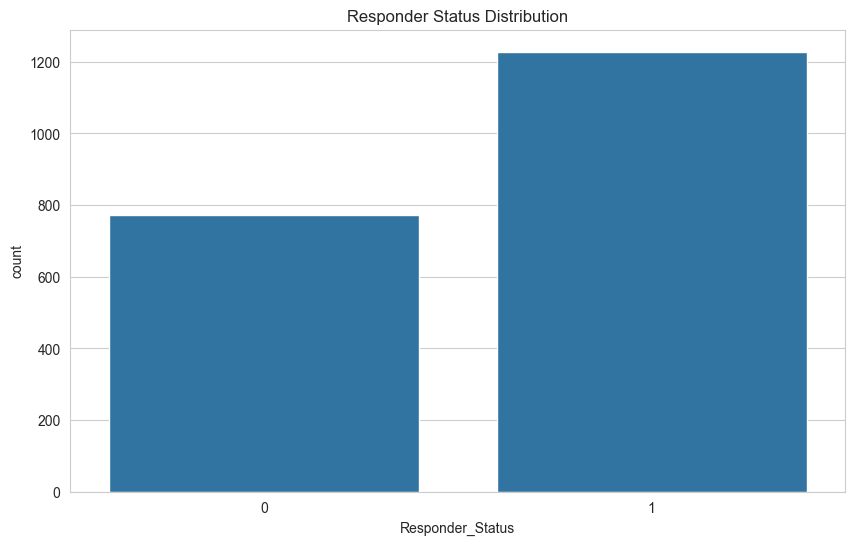

Responder_Status
1    0.614
0    0.386
Name: proportion, dtype: float64


In [156]:
# Distribution of Responder_Status
sns.countplot(x='Responder_Status', data=df)
plt.title('Responder Status Distribution')
plt.show()

# Proportion
print(df['Responder_Status'].value_counts(normalize=True))

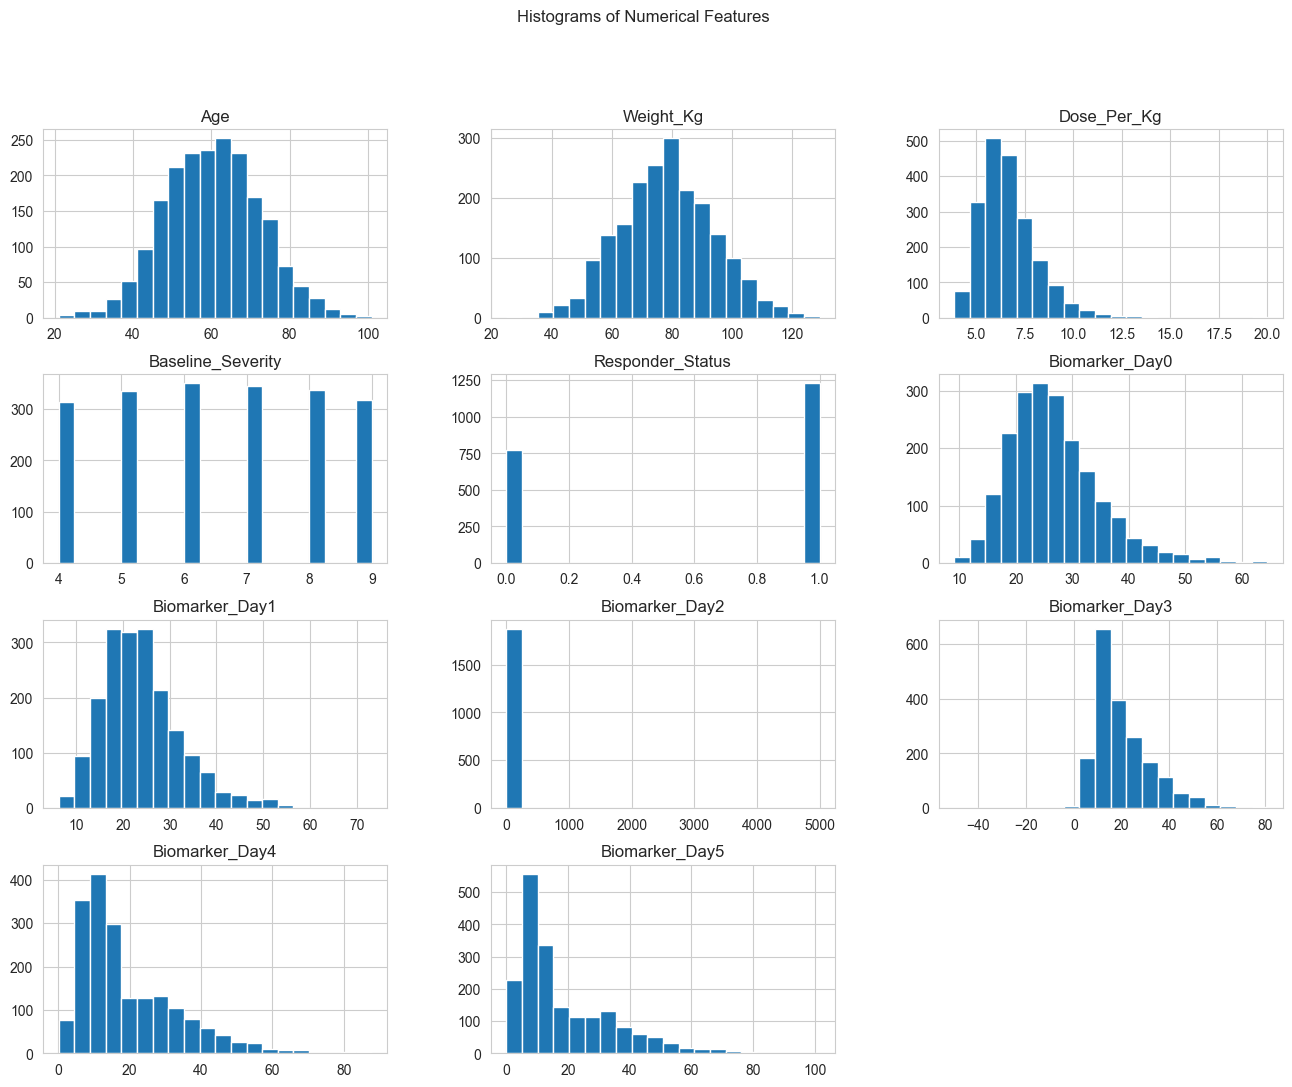

               Age    Weight_Kg  Dose_Per_Kg  Baseline_Severity  \
count  2000.000000  2000.000000  2000.000000        2000.000000   
mean     59.791500    78.171000     6.679212           6.504500   
std      12.227828    15.594722     1.492228           1.679402   
min      21.000000    25.000000     3.875969           4.000000   
25%      51.000000    67.750000     5.617978           5.000000   
50%      60.000000    78.000000     6.410256           6.500000   
75%      68.000000    89.000000     7.380378           8.000000   
max     101.000000   129.000000    20.000000           9.000000   

       Responder_Status  Biomarker_Day0  Biomarker_Day1  Biomarker_Day2  \
count       2000.000000     2000.000000     1897.000000     1877.000000   
mean           0.614000       26.767738       24.038004       24.651210   
std            0.486952        8.021094        8.519652      115.332062   
min            0.000000        9.060611        6.263442        1.185623   
25%            0.0000

In [157]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols].hist(bins=20, figsize=(16, 12))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Descriptive statistics
print(df[num_cols].describe())

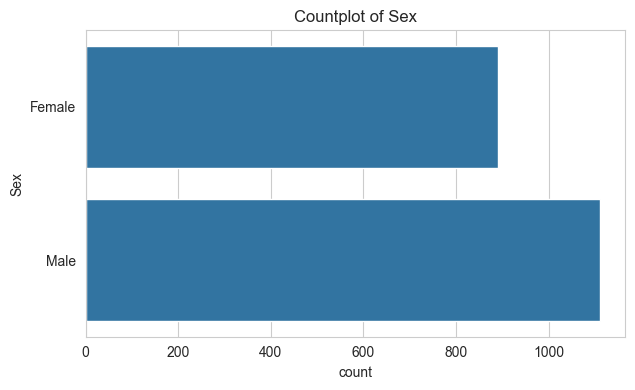

In [158]:
import math

cat_cols = [col for col in df.select_dtypes(include=['object']).columns if col != 'Patient_ID']
n = len(cat_cols)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Countplot of {col}')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

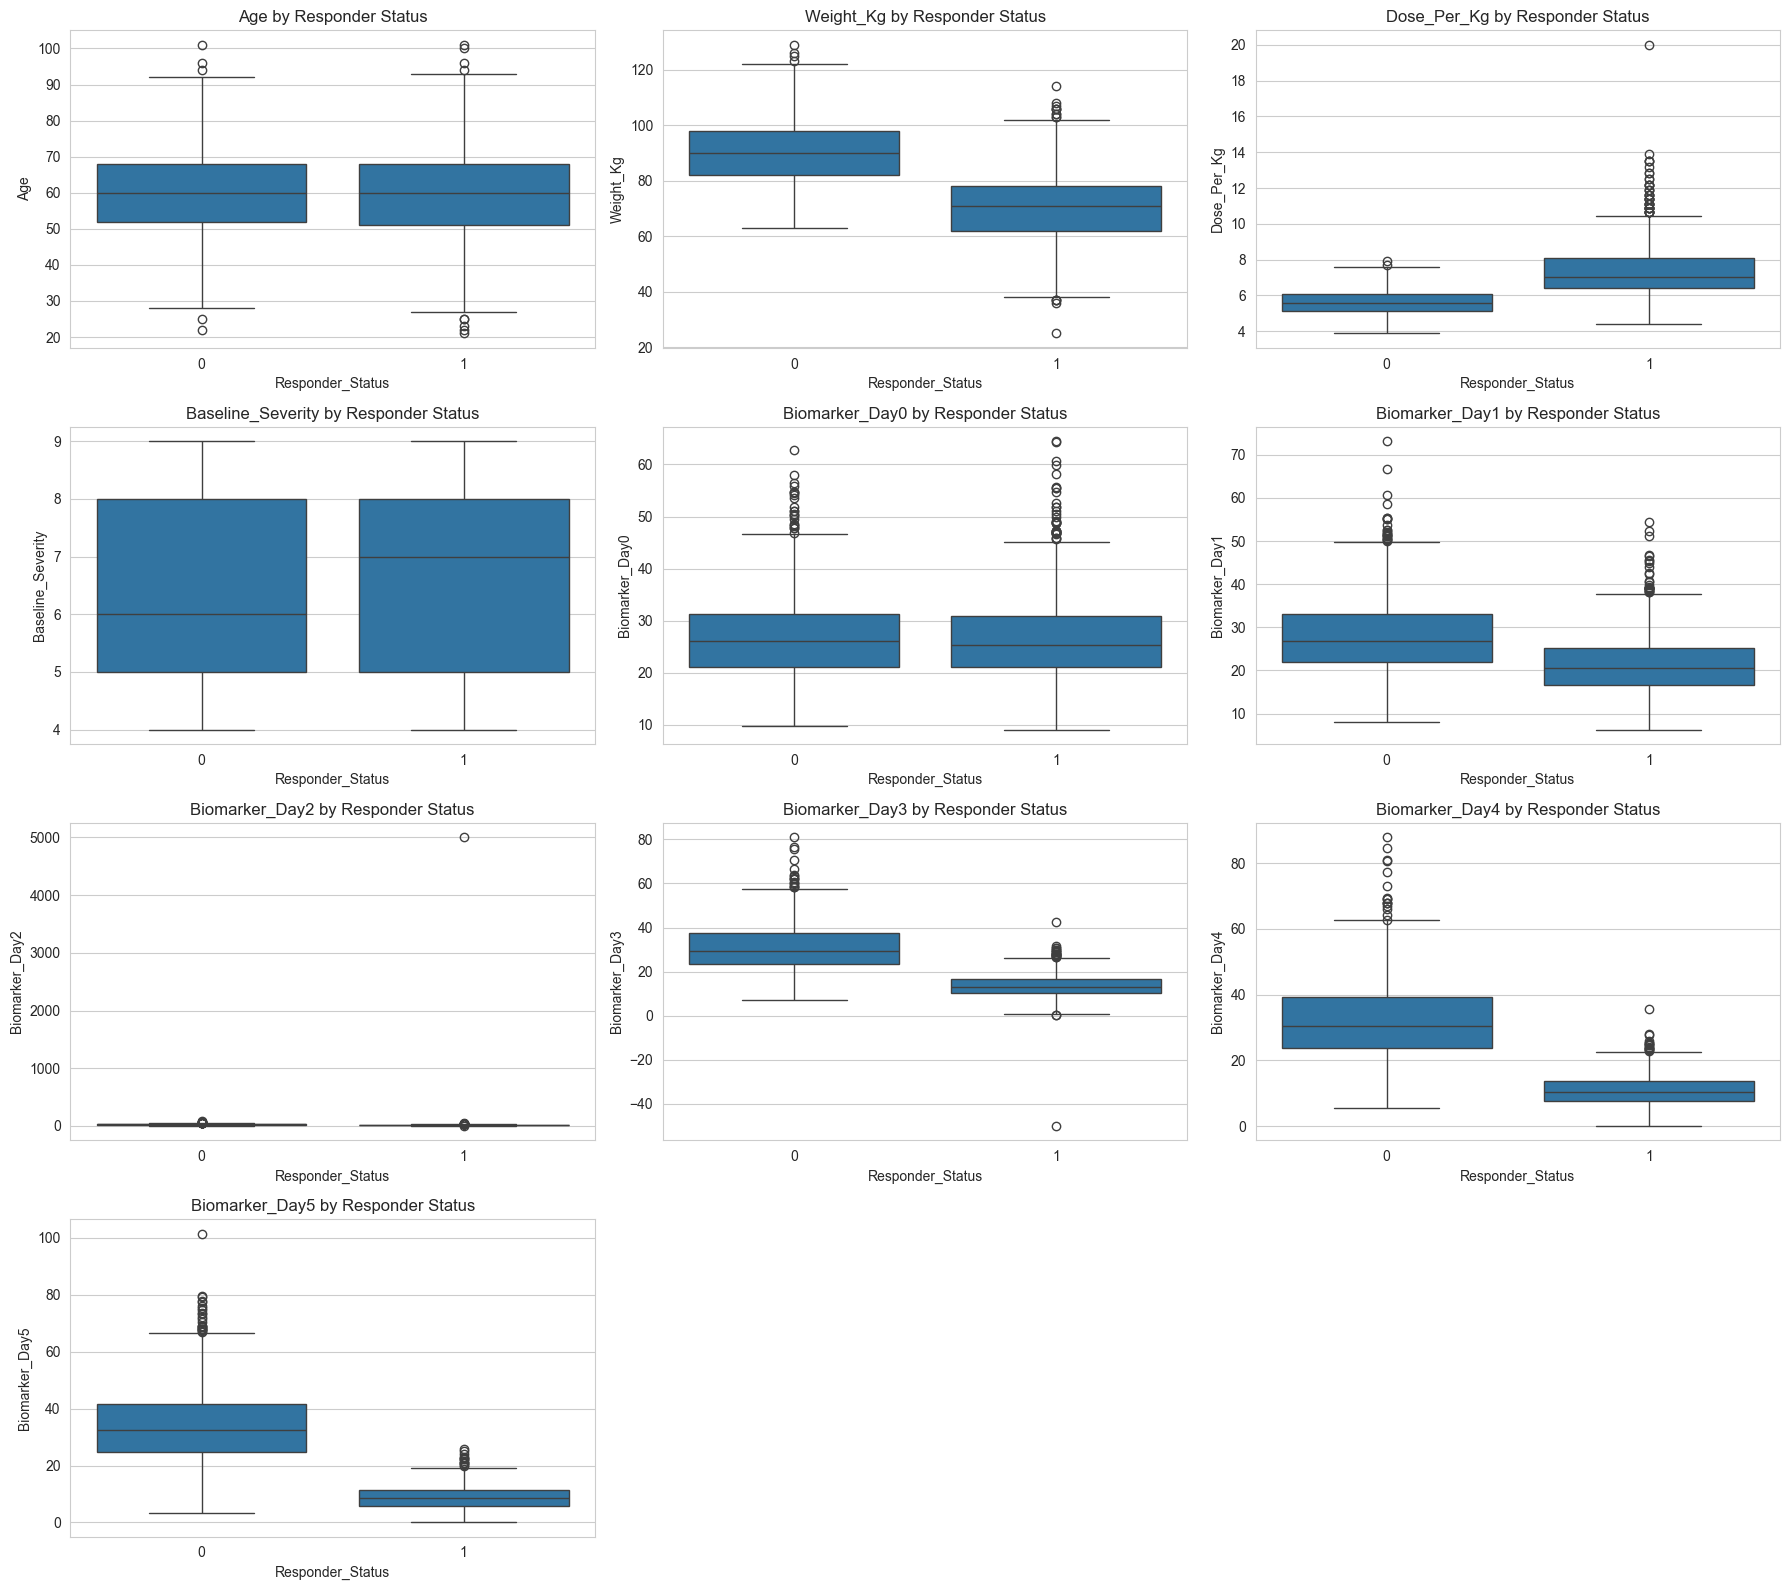

In [159]:
num_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'Responder_Status']
n = len(num_cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x='Responder_Status', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Responder Status')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

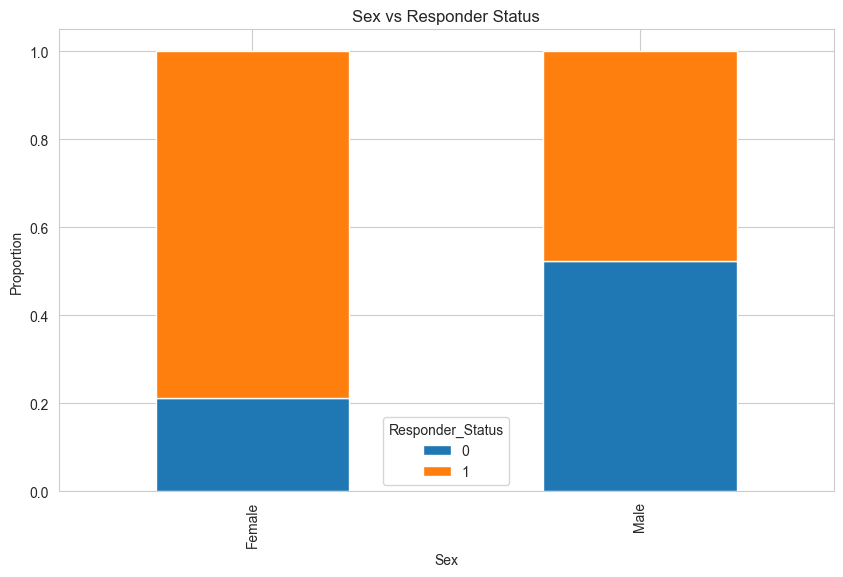

In [160]:
for col in cat_cols:
    if col != 'Patient_ID':
        ct = pd.crosstab(df[col], df['Responder_Status'], normalize='index')
        ct.plot(kind='bar', stacked=True)
        plt.title(f'{col} vs Responder Status')
        plt.ylabel('Proportion')
        plt.show()

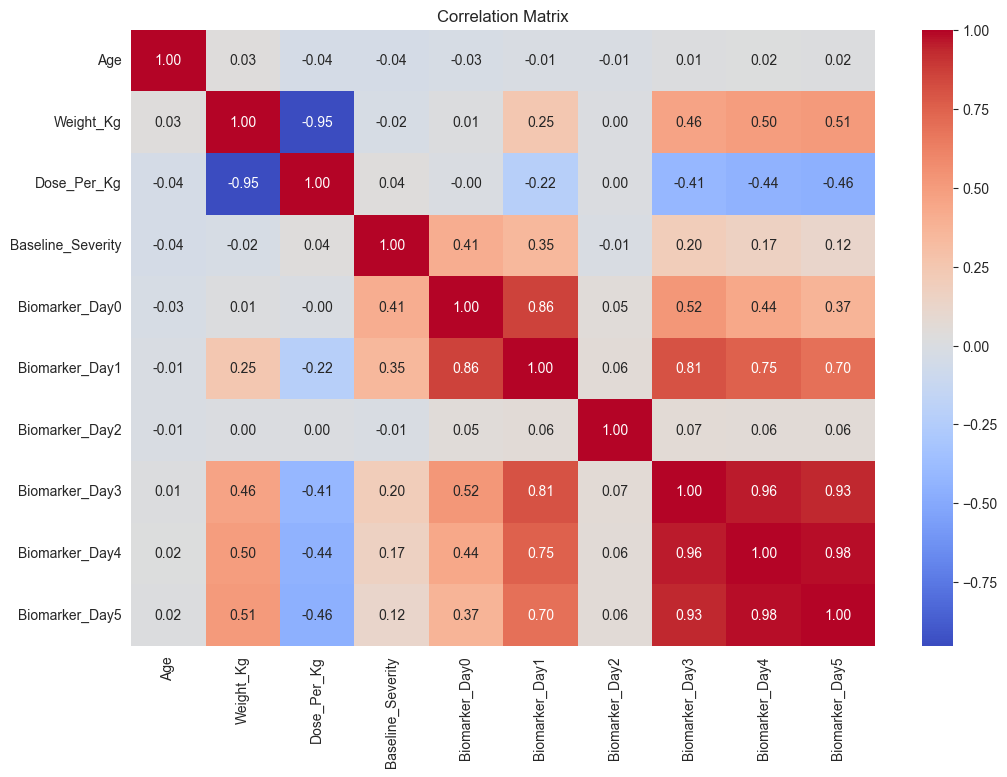

In [161]:
corr = df[num_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

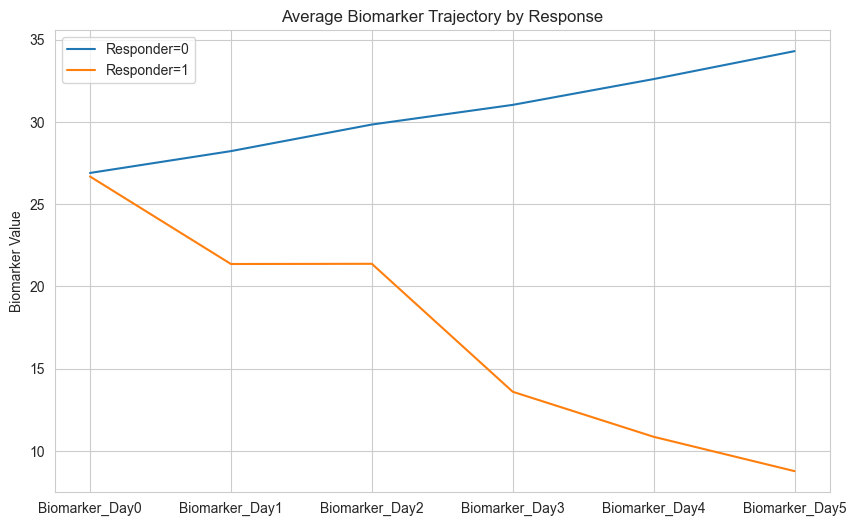

In [162]:
# Plot average biomarker trajectory for responders vs non-responders
biomarker_days = [c for c in df.columns if 'Biomarker_Day' in c]
for status in [0, 1]:
    mean_traj = df[df['Responder_Status'] == status][biomarker_days].mean()
    plt.plot(biomarker_days, mean_traj, label=f'Responder={status}')
plt.legend()
plt.title('Average Biomarker Trajectory by Response')
plt.ylabel('Biomarker Value')
plt.show()

In [163]:
# ==========================================
# 3. Data Cleaning & Feature Engineering
# ==========================================

# --- A. Cleaning & Imputation ---
print("Cleaning data...")
num_cols = [c for c in df.columns if 'Biomarker' in c]

# 1. Handle Sensor Errors (Negative or extreme values)
# We use .mask() which is faster and cleaner than .apply()
# Based on data analysis, values > 1000 or < 0 are artifacts.
for col in num_cols:
    df[col] = df[col].mask((df[col] < 0) | (df[col] > 1000), np.nan)

# 2. Imputation (Linear Interpolation for Time-Series)
# limit_direction='both' ensures we backfill Day 0 if it's missing (rare) 
# and forward fill Day 5 if it's missing.
df[num_cols] = df[num_cols].interpolate(method='linear', axis=1, limit_direction='both')

# --- B. Feature Engineering ---
print("Engineering clinical features...")
# 1. Trajectory Features
df['Total_Change'] = df['Biomarker_Day5'] - df['Biomarker_Day0']
# Added 1e-6 to avoid division by zero error, just in case
df['Pct_Change'] = (df['Biomarker_Day5'] - df['Biomarker_Day0']) / (df['Biomarker_Day0'] + 1e-6)
df['Early_Change'] = df['Biomarker_Day2'] - df['Biomarker_Day0']
df['Late_Change'] = df['Biomarker_Day5'] - df['Biomarker_Day3']

# 2. Volatility (Stability of the patient)
df['Biomarker_Volatility'] = df[num_cols].std(axis=1)

# --- C. Outlier Capping (IQR Method) ---
print("Capping outliers...")
cols_to_cap = ['Total_Change', 'Pct_Change', 'Biomarker_Volatility', 'Early_Change', 'Late_Change']

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    low_limit = Q1 - 1.5 * IQR
    high_limit = Q3 + 1.5 * IQR
    
    # LOGIC FIX: Volatility cannot be negative (Standard Deviation >= 0)
    if 'Volatility' in col:
        low_limit = max(0, low_limit)
        
    df[col] = df[col].clip(lower=low_limit, upper=high_limit)

print("Data ready for modeling.")

Cleaning data...
Engineering clinical features...
Capping outliers...
Data ready for modeling.


In [164]:
df.head()

,Patient_ID,Age,Sex,Weight_Kg,Dose_Per_Kg,Baseline_Severity,Responder_Status,Biomarker_Day0,Biomarker_Day1,Biomarker_Day2,Biomarker_Day3,Biomarker_Day4,Biomarker_Day5,Total_Change,Pct_Change,Early_Change,Late_Change,Biomarker_Volatility
0,P0000,55,Female,57,8.771930,4,1,24.475772,18.710462,17.185737,15.661013,10.589811,8.050132,-16.425640,-0.671098,-7.290034,-7.610881,5.880191
1,P0001,51,Male,65,7.692308,7,1,38.147798,35.245467,25.447169,18.720334,11.993499,7.530111,-30.617687,-0.802607,-12.700629,-11.190223,12.361490
2,P0002,60,Male,90,5.555556,5,0,49.580291,51.577749,52.194047,45.069320,43.180396,45.408444,-4.171847,-0.084143,2.613756,0.339124,3.775129
3,P0003,53,Female,71,7.042254,8,1,38.870393,30.888352,19.962496,19.973790,14.521031,8.403000,-30.467394,-0.783820,-18.907898,-11.570790,11.069051
4,P0004,53,Male,65,7.692308,7,1,19.678144,12.572271,10.209340,5.903636,3.733401,0.816715,-18.861428,-0.958496,-9.468804,-5.086921,6.816749


In [165]:
# ==========================================
# 4. Modeling (Random Forest)
# ==========================================

# 1. Define Features (X) and Target (y)
# Note: We drop Weight_Kg because Dose_Per_Kg is the cleaner interaction feature
X = df.drop(['Patient_ID', 'Responder_Status', 'Weight_Kg'], axis=1)
y = df['Responder_Status']

# 2. Encode Categoricals
X = pd.get_dummies(X, columns=['Sex'], drop_first=True)

# 3. Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Scaling (Standardization)
# We scale Dose_Per_Kg so the model treats it fairly alongside Age/Severity
scaler = StandardScaler()
cols_to_scale = ['Age', 'Baseline_Severity', 'Biomarker_Day0', 'Dose_Per_Kg']

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# 5. Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8, 
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# Save for API later
joblib.dump(rf_model, "../models/clinical_response_model.pkl")
joblib.dump(scaler, "../models/clinical_scaler.pkl")
print("Model trained and artifacts saved.")

Training Random Forest...
Model trained and artifacts saved.



Classification Report:
               precision    recall  f1-score   support

Non-Responder       0.98      0.99      0.98       154
    Responder       0.99      0.99      0.99       246

     accuracy                           0.99       400
    macro avg       0.99      0.99      0.99       400
 weighted avg       0.99      0.99      0.99       400


Feature Importances:
[0.24853168 0.21781463 0.12306905 0.10767242 0.09671385 0.07568299
 0.0380232  0.03319185 0.02991787 0.01163404 0.00745549 0.00572739
 0.00332114 0.00072831 0.00051608]


/var/folders/ht/nzdy16956nn31fzcx6g4kq1h0000gn/T/ipykernel_32644/2942451755.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15], palette='viridis', ax=axes[3])


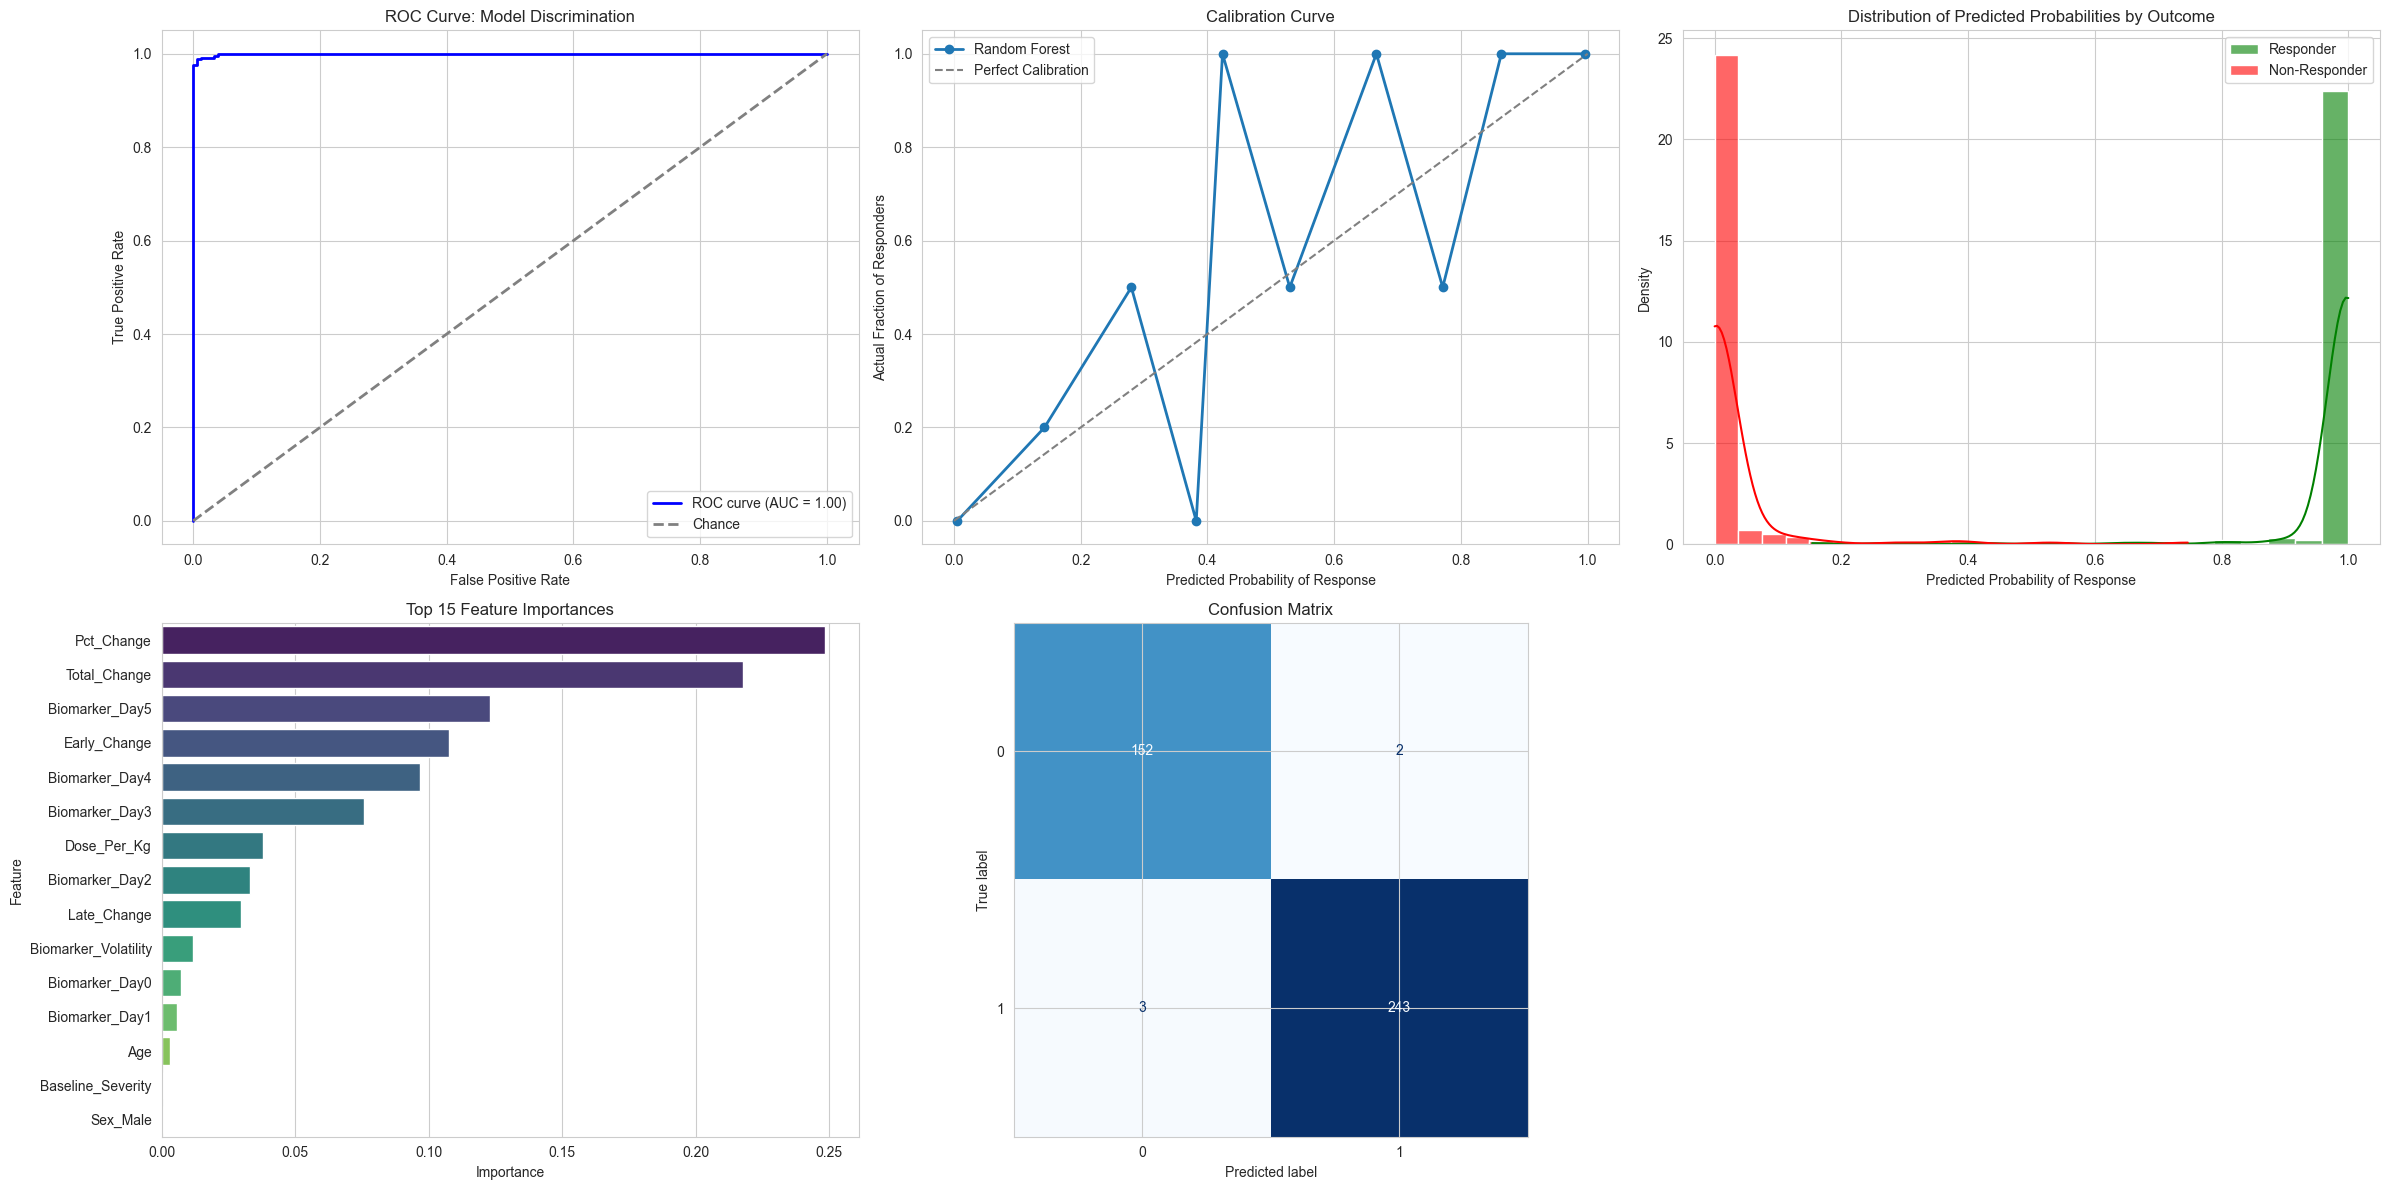

In [166]:
# ==========================================
# 5. Evaluation: Safety & Performance
# ==========================================

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Responder', 'Responder']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

# Set up grid: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

# ROC Curve
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve: Model Discrimination')
axes[0].legend(loc="lower right")

# Calibration Curve
axes[1].plot(prob_pred, prob_true, marker='o', linewidth=2, label='Random Forest')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[1].set_xlabel('Predicted Probability of Response')
axes[1].set_ylabel('Actual Fraction of Responders')
axes[1].set_title('Calibration Curve')
axes[1].legend()

# Distribution by Outcome
sns.histplot(y_prob[y_test == 1], bins=20, color='green', label='Responder', kde=True, stat="density", alpha=0.6, ax=axes[2])
sns.histplot(y_prob[y_test == 0], bins=20, color='red', label='Non-Responder', kde=True, stat="density", alpha=0.6, ax=axes[2])
axes[2].set_xlabel('Predicted Probability of Response')
axes[2].set_ylabel('Density')
axes[2].set_title('Distribution of Predicted Probabilities by Outcome')
axes[2].legend()

# Feature Importance
sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15], palette='viridis', ax=axes[3])
axes[3].set_title('Top 15 Feature Importances')
axes[3].set_xlabel('Importance')
axes[3].set_ylabel('Feature')
print("\nFeature Importances:")
print(importances[indices][:15])

# Confusion Matrix
disp.plot(ax=axes[4], cmap='Blues', colorbar=False)
axes[4].set_title('Confusion Matrix')

# Hide the last (empty) subplot if not used
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/ht/nzdy16956nn31fzcx6g4kq1h0000gn/T/ipykernel_32644/369691998.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_test, plot_type="dot", show=False)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to o

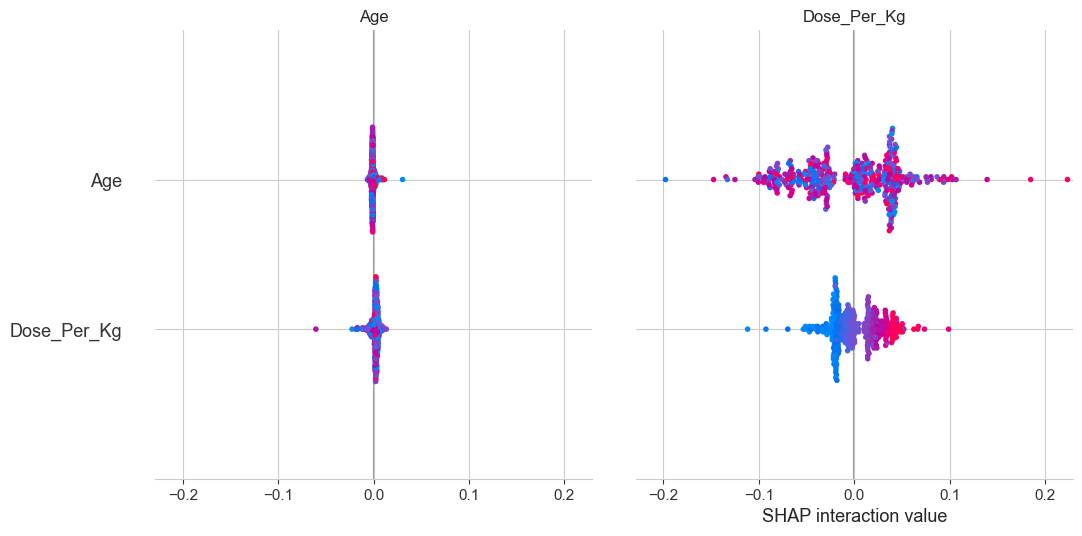

In [167]:
# ==========================================
# 6. Interpretability: Why did the model predict this?
# ==========================================
import matplotlib.pyplot as plt
import shap

# Initialize Explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# 1. Select the correct SHAP values for the "Responder" class (Class 1)
# Random Forest classifiers return a list of arrays (one for each class).
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values

# 2. Plot with show=False so we can modify it
shap.summary_plot(vals, X_test, plot_type="dot", show=False)

# 3. FORCE the size change on the active figure
plt.gcf().set_size_inches(38, 5)

# 4. Now show it
plt.show()

# Insight:
# - Look for Dose_Per_Kg. 
# - You should see that LOW values (blue dots) have negative SHAP values (pushing towards Non-Response).